# Privacy-preserving machine learning with two agents
## Using homomorphic encryption over the titanic challenge

Author:

Arthur Pignet - apignet@equancy.com
    

### Objectives
This notebook aims to demonstrate the faisibility of private machine learning.

We got two agents, Bob and Alice. Bob has data, and wants to extract value from it. But Bob has no clue about data science and needs someone to help him to properly exploite his data. Bob contacts Alice, data scientist, to do so. Here, Bob's project is to create a model that predicts which passengers survived the Titanic shipwreck. He initialy has a datase which contains the details of a subset of the passengers on board (891 to be exact) and importantly, will reveal whether they survived or not. As the Titanic was an european ship, these data are under the GRPD reglementation. 

Therefore the problematic is how Alice can do her job of datascientist without seeing the private data.

A part of the answer relies in homomorphic encryption. This kind of encryption allows one to make computation on encrypted data, without decrypting it, to obtain encrypted result. 

Here Bob will preprocess his data, then will encrypt its using the CKKS encryption scheme.
Alice will receive the encrypted data, and train a model on it. 
Finally Alice will be able to use this model to make (encrypted) prediction for Bob.
Once the model trained, Bob will send new (encrypted) data, (like test data, or unlabeled data),and got a encrypted prediction from Alice, that he will be able to decrypt. 

## This notebook shows the Bob's side

## Setup 

All modules are mandatory. Make sure to import them all by running the cell below

In [1]:
import logging
import os
import socket
import sys
import time

import numpy as np
import pandas as pd
import pickle as pk
import tenseal as ts

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, f1_score, recall_score, precision_score, accuracy_score
                           
os.chdir("/home/apignet/homomorphic-encryption/ckks_titanic/")
from src.features import build_features
from src.communication import Actors

In [2]:
%load_ext memory_profiler

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
1

1

# Definition of parameters

### Paths

The raw data location, the log file location, and the output directory location

In [4]:
WORKING_DIR = os.getcwd()
SUBMISSION_PATH = WORKING_DIR+"/data/submission/"
DATA_PATH = WORKING_DIR+"/data/raw/"            # whole data set
#DATA_PATH = WORKING_DIR+"/data/quick_demo/"   # subset of the data set, with 15 train_samples and 5 test_samples


LOG_PATH = WORKING_DIR+"/reports/log/"
LOG_FILENAME = "Bob"

### Log

Log parameters, for the logging librairy. The log will be printed on the notebook and stored on a file. 

In [5]:
fileHandler = logging.FileHandler("{0}/{1}.log".format(LOG_PATH, LOG_FILENAME))
streamHandler = logging.StreamHandler(sys.stdout)
logging.basicConfig(format="%(asctime)s  [%(levelname)-8.8s]  %(message)s", 
                    datefmt='%m/%d/%Y %I:%M:%S %p', 
                    level = logging.INFO, 
                    handlers=[fileHandler, streamHandler]
                   )

### Socket Variables

Bob and Alice will communicate though the socket module, and so will use these parameters.
The port is the port on which the communication is going to be made
The packet_size defines the size (in bytes) of the batch that will be sent and received
The sentinel is a binary that will be sent to warn the other side that the message is complete.

In [6]:
HOST = '127.0.0.1'  # The server's hostname or IP address
PORT = 65431        # The port used by the server
PACKETS_SIZE = 16384
SENTINEL = b'BREAK'

# Loading and processing the data

Bob starts by loading the data, and preprocess it. For more infomations on preprocessing and feature engineering, see the notebook 1-ap-processing 

In [7]:
%%memit
logging.info(os.getcwd())
raw_train, raw_test = build_features.data_import(DATA_PATH)
train, submission_test = build_features.processing(raw_train, raw_test)

08/10/2020 12:28:07 PM  [INFO    ]  /home/apignet/homomorphic-encryption/ckks_titanic
08/10/2020 12:28:07 PM  [INFO    ]  loading the data into memory (pandas df)
08/10/2020 12:28:07 PM  [INFO    ]  Done
08/10/2020 12:28:07 PM  [INFO    ]  making final data set from raw data
08/10/2020 12:28:08 PM  [INFO    ]  Done
peak memory: 165.64 MiB, increment: 12.99 MiB


We use 15 % of the dataset as test set, and will send it to Alice only when the model had been trained. 

In [8]:
%%memit
train, test = train_test_split(train, test_size=0.15)
train_labels = train.Survived
test_labels = test.Survived
train_features = train.drop("Survived", axis=1)
test_features = test.drop("Survived", axis=1)

peak memory: 165.98 MiB, increment: 0.10 MiB


# Homomorphic encryption

Homomorphic encryption allowing private computations on the encrypted data, without having to decrypt its. Here Bob will encrypt the data, and will had Alice made the computation (model training). Alice will never see the plain data, and thus the dataset will stay private. Besides, this king of encryption suffers from huge draw back, as increasing memory/time complexity, and limited calculus depth per ciphertext. Indeed, for most of the homomorphic encryption (HE) schemes, the number of operation (like multiplication and addition) is limited. After performing a finite number of multiplication on a ciphertext, one will not be able to decrypt it properly. Some schemes by pass this limitation, but always at important costs, in memory or time computation. 

### Choice of the encryption scheme 

The encryption will be done with the tenseal library, which is build on the top of the Microsoft SEAL software.
The two encryption schemes avaible in SEAL are BFV and CKKS. Here, we choose to use the CKKS sheme, which is designed to made floating point operations, at the opposite of the BFV scheme, which handles only intergers. 

### Definition of safety parameters

The choice of the safety parameters (poly_modulus_degree, coeff_mod_bit_sizes, and global_scale) is cruciale. It is them that will define the memory size of our ciphertext, the floating precision of our operations, and the calculus depth limite.

A really good understanding of the CKKS scheme functionning is requiered to properly set up these parameters. 

In the CKKS scheme, the plaintext vextors are first converted into polynomials with integer coefficients, which are then map by a ring isomorphisme in the ring FORMULE ICI.

The number of slots in a ciphertext is poly_modulus_degree / 2 and each slot encodes one real or complex number. While encoding a smaller vector, the SEAL CKKSEncoder will implicitly pad itwith zeros to full size (poly_modulus_degree / 2) when encoding. Thus, the memory size of a ciphertext is definied by the poly_modulus.

Moreover, to convert the plaintext into polynomial, the floating-point coefficients of the input will be scaled up by the parameter gloabl_scale. The scale can be seen as determining the bit-precision of the encoding. The ismorphism will store our messages modulo coeff_modulus, so the scaled message must not get too close to the total size of coeff_modulus. Otherwise, the decrypted result will make no sense. Therefore, the choice of the scale will participate to the precision of our operations, and is strongly relies to the choice of the poly_modulus.  

As ciphertext multiplications are done as polynomial multiplications, we need to relinearize the polynom to obtain a result that has the same size as the initial ciphertexts (In fact this operation is not mandatory, but is done after every mutiplication in our application. See the documentation for more information). It is done with a special key (relin_key), and as a side-effect, makes the scale dramaticly increase. The scale of any ciphertext must not get too close to the total size of coeff_modulus, or else the ciphertext simply runs out of room to store the scaled-up plaintext. The CKKS scheme provides a rescale functionality that can reduce the scale, and stabilize the scale expansion. 

This rescale operation removes the last of the primes from coeff_modulus, but as a side-effect it scales down the ciphertext by the removed prime. More precisely, suppose that the scale in a CKKS ciphertext is S, and the last prime in the current coeff_modulus (for the ciphertext) is P. Rescaling to the next level changes the scale to S/P, and removes the prime P from the coeff_modulus, as usual in modulus switching. The number of primes limits how many rescalings can be done, and thus limits the multiplicative depth of the computation. It is possible to choose the initial scale freely. One good strategy can be to is to set the initial scale S and primes P_i in the coeff_modulus to be very close to each other. If ciphertexts have scale S before multiplication, they have scale S^2 after multiplication, and S^2/P_i after rescaling. If all P_i are close to S, then S^2/P_i is close to S again. This way we stabilize the scales to be close to S throughout the computation. Generally, for a circuit of depth D, we need to rescale D times, i.e., we need to be able to remove D primes from the coefficient modulus. Once we have only one prime left in the coeff_modulus, the remaining prime must be larger than S by a few bits to preserve the pre-decimal-point value of the plaintext.

sources : 
SEAL tutorials 

https://github.com/microsoft/SEAL/blob/master/native/examples/1_bfv_basics.cpp
https://github.com/microsoft/SEAL/blob/master/native/examples/2_encoders.cpp               
https://github.com/microsoft/SEAL/blob/master/native/examples/3_levels.cpp
https://github.com/microsoft/SEAL/blob/master/native/examples/4_ckks_basics.cpp

from https://github.com/microsoft/SEAL/blob/master/native/examples


In [9]:
%%memit
logging.info('Definition of safety parameters...')
timer = time.time()

context = ts.context(ts.SCHEME_TYPE.CKKS, 16384, coeff_mod_bit_sizes=[60, 40, 40, 40, 40, 40, 40,40, 60])
context.global_scale = pow(2, 40)
logging.info("Done. " + str(round(time.time() - timer, 2)) + " seconds")





08/10/2020 12:28:09 PM  [INFO    ]  Definition of safety parameters...
08/10/2020 12:28:09 PM  [INFO    ]  Done. 0.31 seconds
08/10/2020 12:28:09 PM  [INFO    ]  Generation of the secret key...
08/10/2020 12:28:09 PM  [INFO    ]  Done. 0.0 seconds
08/10/2020 12:28:09 PM  [INFO    ]  Generation of the Galois Key...
08/10/2020 12:28:12 PM  [INFO    ]  Done. 3.3 seconds
08/10/2020 12:28:12 PM  [INFO    ]  Generation of the Relin Key...
08/10/2020 12:28:12 PM  [INFO    ]  Done. 0.13 seconds
08/10/2020 12:28:12 PM  [INFO    ]  The context is now public, the context do not hold the secret key anymore, and decrypt    methods need the secret key to be provide,
08/10/2020 12:28:12 PM  [INFO    ]  serialization of the context started...
08/10/2020 12:29:01 PM  [INFO    ]  Serialization done in 48.882649421691895 seconds
peak memory: 1593.52 MiB, increment: 1427.54 MiB


The context is the main tenseal object. When created, it holds the secret and public keys. So it is needed to encrypt a vector.We can add to this context the relin's and Galois' keys. These keys are mandatory for every computation, therefore every vector encrypted with a specific context holds as an attribut a pointeur on the context. Moreover,if the context is private (ie holds the secret key), the method decrypt() on a vector will not need the secret key, as it can be accessed with vector.context.secret_key.
It really convenient for computations but raise on issue on serialization, as we will see later.

Alice will need the relin's and Galois' keys, so Bob will send the context to Alice, obviously without the secret key. So Bob will store the secret key, and will have the context drop it. Then Bob can generate the relin/galois keys, and sent it to Alice. 

In [ ]:
logging.info('Generation of the secret key...')
timer = time.time()
secret_key = context.secret_key()
context.make_context_public() #drop the relin keys, the galois keys, and the secret keys. 
logging.info("Done. " + str(round(time.time() - timer, 2)) + " seconds")
logging.info('Generation of the Galois Key...')
timer = time.time()
context.generate_galois_keys(secret_key)
logging.info("Done. " + str(round(time.time() - timer, 2)) + " seconds")
logging.info('Generation of the Relin Key...')
timer = time.time()
context.generate_relin_keys(secret_key)
logging.info("Done. " + str(round(time.time() - timer, 2)) + " seconds")
if context.is_public():
    logging.info("The context is now public, the context do not hold the secret key anymore, and decrypt\
    methods need the secret key to be provide,")
logging.info("serialization of the context started...")
timer = time.time()
b_context = context.serialize()
logging.info("Serialization done in %s seconds" %(time.time()-timer))


# Esthablishing the communication with Alice

The computation, the training of the model will be done by Alice. We need to esthablishe a communication between the two actors to pass encrypted data, encrypted prediction, and the keys which are mandatory for the computation (in fact Bob will pass the full public context (ie without the secret key).

### Actors

Here we use the homemade calss actors. When initialized an actor tries to connect to the adress/ort which is passed as parameter (client role). If nobody is listening, the actor bind a socket and listen to it, waiting for a actor. 

For the transmission, an actor sents packet of the size PACKET_SIZE, and wait that the other actor replied b'next', which means that the packet had been received, and that it is waiting for the next packet. If the message is not completely sent, the actors itere the process. Else, the transmiting actor sends b'DONE' to signal to the other actor that all the packets had been sent, and the full message can be deserialize, or use...  

In [23]:
ALICE = Actors.Actor(HOST, PORT, PACKETS_SIZE, SENTINEL)

08/06/2020 03:45:29 PM  [INFO    ]  Nobody is listening, binding a server...
08/06/2020 03:45:34 PM  [INFO    ]  Connected by 127.0.0.1:49688


### Sending the public context

Alice needs the context. The context is already ready, it is public and holds the three keys needed by Alice. We first need to serialize it. Keep in mind that the context with these keys is heavy in memory (around 500 Mb if you did not change the safety parameters)

In [11]:
logging.info("serialization of the context started...")
timer = time.time()
b_context = context.serialize()
logging.info("Serialization done in %s seconds. Sending the context..." %(time.time()-timer))
ALICE.transmission(b_context)
logging.info('The context has been sent')

08/06/2020 02:31:04 PM  [INFO    ]  The context has been sent


### Crypting, serializing and sending the crypted data

The data are currectly pandas dataframe, but tenseal needs list as input. We first use numpy for reshape

In [12]:
logging.info("Data encryption/serialization/ transfert to Alice...")
timer = time.time()

plain_X = train_features.to_numpy().tolist()
plain_Y = train_labels.to_numpy().reshape((-1,1)).tolist()

08/06/2020 02:31:04 PM  [INFO    ]  Data encryption/serialization/ transfert to Alice...


We first sending to Alice the amouth of data she is supposed to receive, and the number of features in it. 

The amouth of data is useful for Alice, to initialize variable and know when stop listening for message. Alice also needs the number of features to initialize the weight and bias. 


In [13]:
ALICE.transmission(pk.dumps(train_features.shape))

11

While encrypting the data, we also serialize it, ie convert it in binary, which will be sent to Alice. 

It is interesting to denote that while being serialize, ckks vector drops its context. If we pickle it in the standart way, by serilaizing every attribute, we will serialize the context (500 Mb) for every vector. So we serialize the context, sent it, serialize the vectors, which drop the context reference during the process. When Alice will deserialize the Bob's encrypted data, she will provide the context which these vectors will use for computations.

We want to sent to Alice a easy-to-read object, so we send a dictionary, with explicit keys(id, features, label). The "id" is here to allow Alice to shuffle the dataset, during multiprocessing for instance, and still recover the right label/prediction for the right data. 

We use the pickle module to serialize and deserialize the dict. As the tenseal vector cannot be serialize by pickle for the reasons we evocated few lines ago, we have to first serialize the tenseal object with their own methods, and then ask pickle to serialize a dict containing references to strings, int and binaries.

In [14]:
for i in range(len(plain_X)):
    ser_enc_x = ts.ckks_vector(context, plain_X[i]).serialize()
    ser_enc_y = ts.ckks_vector(context, plain_Y[i]).serialize()
    
    data = pk.dumps({'id':i,
                     'X':ser_enc_x, 
                     'label':ser_enc_y
                    })
    ALICE.transmission(data)
    
    if i == len(plain_X) // 4:
        logging.info("25 % ...")
    elif i == len(plain_X) // 2 :
        logging.info("50 % ...")
    elif i == 3* len(plain_X)//4:
        logging.info("75% ...")
logging.info("Done. " + str(round(time.time() - timer, 2)) + " seconds")
ALICE.transmission(b'DONE')

08/06/2020 02:32:14 PM  [INFO    ]  25 % ...
08/06/2020 02:33:20 PM  [INFO    ]  50 % ...
08/06/2020 02:34:25 PM  [INFO    ]  75% ...
08/06/2020 02:35:31 PM  [INFO    ]  Done. 266.58 seconds


4

# Refreshing the weight

At this point Alice has recieved all she needs. Its work can begin. While training its models, Alice will probably need to make more computations than allowed by the safety parameters (here around 8 mutiplications are allowed before running out of scale). So in order to evaluate calculus circuit of arbitrary depth, Alice needs a "refresh" function, which reset this dept. To do so, Bob will listening to Alice, and when needed, Alice will sent a vector to Bob. Bob will deseriailize it, decrypt it, re-encrypt it, and after serializition, send it back to Alice. Therefore, Alice will receive a freshly encrypted vector, which she will be able to use. She never saw any secret key nor unencrypted data.

When the training is done, Alice annonces to Bob to b'STOP_REFRESH'

We can then skip to the next step, the evaluation of the model


In [15]:
logging.info("Alice says "+str(ALICE.reception().decode()))
while True:
    b_data = ALICE.reception()
    if b_data == b'STOP_REFRESH': break
    logging.info("refreshing a vector...")
    vector = ts.ckks_vector_from(context, b_data)
    decrypted_vector = vector.decrypt(secret_key)
    refreshed_vector = ts.ckks_vector(context, decrypted_vector)
    ALICE.transmission(refreshed_vector.serialize())

08/06/2020 02:36:20 PM  [INFO    ]  Alice says start_fitting
08/06/2020 02:36:36 PM  [INFO    ]  refreshing a vector...
08/06/2020 02:36:37 PM  [INFO    ]  refreshing a vector...
08/06/2020 02:37:32 PM  [INFO    ]  refreshing a vector...
08/06/2020 02:37:33 PM  [INFO    ]  refreshing a vector...
08/06/2020 02:37:33 PM  [INFO    ]  refreshing a vector...
08/06/2020 02:37:34 PM  [INFO    ]  refreshing a vector...
08/06/2020 02:39:18 PM  [INFO    ]  refreshing a vector...
08/06/2020 02:39:19 PM  [INFO    ]  refreshing a vector...
08/06/2020 02:40:14 PM  [INFO    ]  refreshing a vector...
08/06/2020 02:40:15 PM  [INFO    ]  refreshing a vector...
08/06/2020 02:41:10 PM  [INFO    ]  refreshing a vector...
08/06/2020 02:41:11 PM  [INFO    ]  refreshing a vector...
08/06/2020 02:42:06 PM  [INFO    ]  refreshing a vector...
08/06/2020 02:42:07 PM  [INFO    ]  refreshing a vector...
08/06/2020 02:43:02 PM  [INFO    ]  refreshing a vector...
08/06/2020 02:43:03 PM  [INFO    ]  refreshing a vecto

### Getting the loss back

During the training, Alice computed loss. Nevertheless, the loss values are encrypted so she cannot use it at all, so she sent it to Bob for plotting.

Here there is a potential security leack. The loss graphic cannot be sent to Alice, otherwise Alice will have access to a kind of decrypt method. If Alice decide to sent not the loss, but a fake loss constitued with some interesting values (encrypted) to Bob, and Bob send the decrypted fake loss to Alice, Alice will have acess to these sensitive values. 

So even a normalize figure cannot be sent to Alice. Bob will be the only one who can look at the loss (Maybe not ht eonly one, but he cannot sent it back to ALice)

In [16]:
epoch, enc_loss = pk.loads(ALICE.reception())
loss = [ts.ckks_vector_from(context,l).decrypt(secret_key)[0] for l in enc_loss]

### Use Alice to make prediction

As Bob was previously continuously listening for vector to refresh, now Alice is listening to Bob, waiting for data to do inference on it. So Bob will use Alice's model to make predictions over a test set, and after getting a good evaluation of Alice's model, he will sent fresh data, to get predictions.

It is important to denote that, even if we spoke only of predictions, Alice does not really sent predictions, but probability. The output of Alice model corresponds to the probability of being in the class 1. Bob can round the decrypted result to get the label prediction (0 if the probability is above 0.5, and 1 if it is higher). One can choose to use a threshold differente from 0.5, for instance if less risk on the prediction of one class is needed. This choice has to be made by Bob, as Alice cannot do comparison between ciphertext. 

In [17]:
logging.info("Test data encryption/serialization/ transfert to Alice...")
timer = time.time()

plain_test_X = test_features.to_numpy().tolist()
proba_predictions = [None for _ in range(len(plain_test_X))]

08/06/2020 03:31:40 PM  [INFO    ]  Data encryption/serialization/ transfert to Alice...


In [18]:
logging.info("Asking Alice for prediction")
timer = time.time()
for i in range(len(plain_test_X)):
    ser_enc_x = ts.ckks_vector(context, plain_test_X[i]).serialize()
    data = pk.dumps([i,ser_enc_x])
    ALICE.transmission(data)
    key, enc_ser_pred = pk.loads(ALICE.reception())
    proba_predictions[key] = ts.ckks_vector_from(context, enc_ser_pred).decrypt(secret_key)
    if i == len(plain_X) // 4:
        logging.info("25 % ...")
    elif i == len(plain_X) // 2 :
        logging.info("50 % ...")
    elif i == 3* len(plain_X)//4:
        logging.info("75% ...")
logging.info("Done. " + str(round(time.time() - timer, 2)) + " seconds")
assert not (None in proba_predictions), 'Missing predictions'

08/06/2020 03:31:40 PM  [INFO    ]  Asking Alice for prediction
08/06/2020 03:32:47 PM  [INFO    ]  Done. 67.47 seconds


# Evaluation of the model

Once Bob got predictions on test set and loss, he can evaluate some metrics on Alice's model

## Loss

Text(0.5, 1.0, 'Loss evolution over epochs')

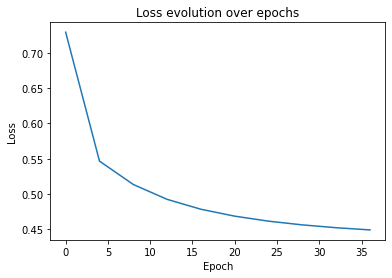

In [19]:
plt.plot(epoch,
         loss)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss evolution over epochs')

### Metrics

08/06/2020 03:32:47 PM  [INFO    ]  Precision score of encrypted model on test set: 0.7333333333333333 
08/06/2020 03:32:47 PM  [INFO    ]  Recall score  of encrypted model on test set : 0.6470588235294118 
08/06/2020 03:32:47 PM  [INFO    ]  F1 score of encrypted model on test set: 0.6875 
08/06/2020 03:32:47 PM  [INFO    ]  Accuracy of encrypted model on train set : 0.7938144329896907 


<AxesSubplot:>

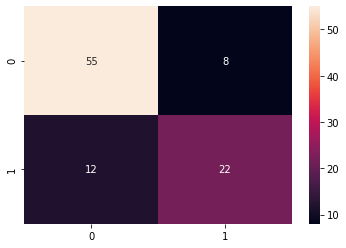

In [20]:
prediction = 1*(np.array(proba_predictions) > 0.5)
recall = recall_score(test_labels,prediction)
F1 = f1_score(test_labels, prediction)
precision = precision_score(test_labels, prediction)
cf_m=confusion_matrix(test_labels, prediction ) 
accuracy = accuracy_score(test_labels, prediction)

logging.info("Precision score of encrypted model on test set: %s " % precision)
logging.info("Recall score  of encrypted model on test set : %s " % recall)
logging.info("F1 score of encrypted model on test set: %s " % F1)
logging.info("Accuracy of encrypted model on test set : %s " % accuracy)
sns.heatmap(cf_m, annot=True)

Here Bob can be satisfied, the model has a quite good accuracy, even if the F1 score is not that high. Nevertheless, these metrics satisfied Bob, so he decides to use Alice's model to do some real/useful predictions. 

For that, he has a data set, with unlabelled data. Alice is still listening for data to predict on. So like before, Bob sent the encrypted unlabelled data. 

In [24]:
logging.info("New data encryption/serialization/ transfert to Alice for prediction...")
timer = time.time()

plain_test_X = submission_test.to_numpy().tolist()
proba_predictions = [None for _ in range(len(plain_test_X))]

08/06/2020 03:45:55 PM  [INFO    ]  New data encryption/serialization/ transfert to Alice for prediction...


In [25]:
logging.info("Asking Alice for prediction on the new data")
timer = time.time()
for i in range(len(plain_test_X)):
    ser_enc_x = ts.ckks_vector(context, plain_test_X[i]).serialize()
    data = pk.dumps([i,ser_enc_x])
    ALICE.transmission(data)
    key, enc_ser_pred = pk.loads(ALICE.reception())
    proba_predictions[key] = ts.ckks_vector_from(context, enc_ser_pred).decrypt(secret_key)
    if i == len(plain_X) // 4:
        logging.info("25 % ...")
    elif i == len(plain_X) // 2 :
        logging.info("50 % ...")
    elif i == 3* len(plain_X)//4:
        logging.info("75% ...")
logging.info("Done. " + str(round(time.time() - timer, 2)) + " seconds")
assert not (None in proba_predictions), 'Missing predictions'

08/06/2020 03:45:57 PM  [INFO    ]  Asking Alice for prediction on the new data
08/06/2020 03:47:32 PM  [INFO    ]  25 % ...
08/06/2020 03:49:07 PM  [INFO    ]  50 % ...
08/06/2020 03:50:42 PM  [INFO    ]  75% ...
08/06/2020 03:50:48 PM  [INFO    ]  Done. 290.9 seconds


Now Bob has all the predictions he needed, so he informs Alice that he no longer requiere her prediction.

In [28]:
ALICE.transmission(b'STOP_PREDICT')
ALICE.close()

In [1]:
submission_pred = 1*(np.array(proba_predictions) > 0.5)
submission_df = pd.DataFrame({
        "PassengerId": raw_test["PassengerId"],
        "Survived": submission_pred.reshape(-1)
    })
submission_df.head()

NameError: name 'np' is not defined

In [17]:
submission_df.to_csv(SUBMISSION_PATH+'first_sub_alice_bob2.csv', index=False)